## Подготовка данных. Использованы цены закрытия по акциям AMD, TSM, NVDA, MSFT за период с 22.02.2016 по 19.02.2021. Использовались котировки с биржи NASDAQ. 

In [46]:
import pandas as pd
import numpy as np
import scipy.stats

amd = pd.read_csv(r'E:\Downloads\Stock_prices\AMD.csv') #Используем данные по котировкам с NASDAQ (файлы приложены)
nvda = pd.read_csv(r'E:\Downloads\Stock_prices\NVDA.csv')
tsmc = pd.read_csv(r'E:\Downloads\Stock_prices\TSMC.csv')
msft = pd.read_csv(r'E:\Downloads\Stock_prices\msft.csv')

amd_close = amd['Close/Last'].apply(lambda x: float(x[1:])).iloc[::-1].to_numpy() #создаем массивы с ценами закрытия, по возрастанию даты
nvda_close = nvda['Close/Last'].apply(lambda x: float(x[1:])).iloc[::-1].to_numpy()
tsmc_close = tsmc['Close/Last'].apply(lambda x: float(x[1:])).iloc[::-1].to_numpy()
msft_close = msft['Close/Last'].apply(lambda x: float(x[1:])).iloc[::-1].to_numpy()

price_matrix = np.stack([amd_close, nvda_close, tsmc_close, msft_close]) #матрица цен
price_matrix

array([[  2.01,   1.97,   2.02, ...,  89.94,  88.64,  89.58],
       [ 31.52,  31.6 ,  31.82, ..., 596.24, 593.16, 597.06],
       [ 23.96,  23.4 ,  23.42, ..., 136.27, 134.63, 136.66],
       [ 52.65,  51.18,  51.36, ..., 244.2 , 243.79, 240.97]])

### Моделируем динамику цен акций геометрическим броуновским движением, где приращение доходности акций имеет многомерное нормальное распределение. Моделирование проводим 1 000 раз (можно больше для более точного результата, но это занимает достаточно много времени), полученные результаты усредняем. Выполняется следующее, где S - цена акции:
$\LARGE S_{t + 1} = S_t \cdot e^{((\mu - \frac{\sigma^2}{2})dt + W)}$
### Временной шаг dt = 1 день
### W - наблюдение случайной величины, которая имеет многомерное нормальное распределение со средним 0 и матрицей ковариаций доходностей.
### В качестве коэффициента сноса возьмем безрисковую ставку

### Волатильность и матрицу ковариаций зафиксируем на значениях, полученных на исторических данных

### В рамках данного расчета мы пренебрегаем дивидендами 

In [234]:
def stock_future_GBM(price_matrix, r, T_days = 1269): 
#функция моделирует геометрическое броуновское движение нескольких акций, где случайное приращение - винеровский процесс с многомерным нормальным распределением
#даны матрица цен акций, коэффициент сноса (в нашем случае  безрисоквая ставка процента), срок прогнозирования    
    yield_matrix = np.zeros((len(price_matrix), len(price_matrix[0]) - 1)) #Строим матрицу дневных доходностей 
    for i in range(len(price_matrix)):
        yield_matrix[i] = np.log(price_matrix[i][1:]/price_matrix[i][:-1]) 

    volatility = np.zeros(len(price_matrix)) #Считаем волатильность на первый день
    for i in range(len(price_matrix)):
        volatility[i] = np.std(yield_matrix[i], ddof = 1) 

    for t in range(T_days): 
        W = sp.stats.multivariate_normal(cov = np.cov(yield_matrix)).rvs() #задаем случайное приращение, которое имеет многомерное нормальное распределение
        predicted_prices = np.zeros((4, 1))
        for i in range(4): #моделируем цену на шаг вперед
            predicted_prices[i][0] = price_matrix[i][-1]*np.exp((r*np.sqrt(1/365) - 0.5 * volatility[i] ** 2) + W[i])
        price_matrix = np.append(price_matrix, predicted_prices, axis = 1)
    return price_matrix    


def monte_carlo(price_matrix, r, T_days = 1259, I = 1000): #Моделируем движение цены I раз и усредняем
    sum_price_matrix = np.zeros((4,len(price_matrix[0]) * 2))
    for i in range(I):
        print(i, end = '\r') 
        sum_price_matrix = sum_price_matrix + stock_future_GBM(price_matrix, r, T_days)
    sum_price_matrix = sum_price_matrix / I
    return sum_price_matrix

res = monte_carlo(price_matrix, 0.0025, 1259, 1000)
    

### На графике ниже представлены смоделированные цены акций AMD и TSMC на 5 лет вперед.

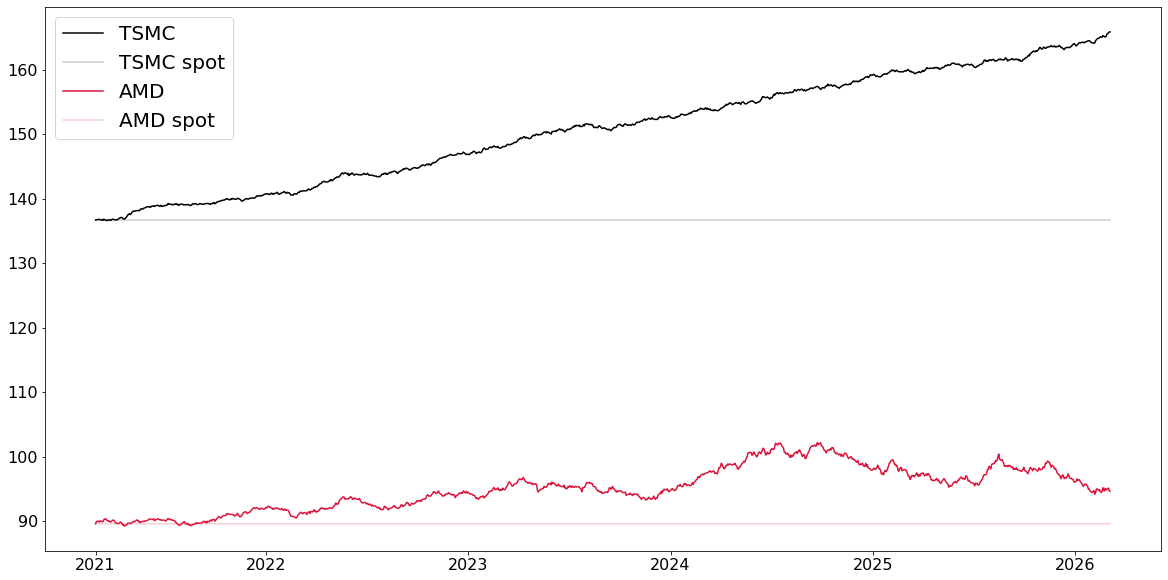

In [248]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot([i for i in range(1259)], res[2][1259:], label = 'TSMC', color = 'black')
plt.plot([i for i in range(1259)], [res[2][1259:1260] for i in range(1259)], label = 'TSMC spot', color = 'black', alpha = 0.2)
plt.plot([i for i in range(1259)],res[0][1259:], label = 'AMD', color = 'crimson')
plt.plot([i for i in range(1259)],[res[0][1259:1260] for i in range(1259)], label = 'AMD spot', color = 'crimson', alpha = 0.2)
plt.legend( prop={'size': 20})
plt.xticks([0, 211, 462, 713, 964, 1215], ['2021', '2022', '2023', '2024', '2025', '2026'])
plt.show()

### График цены NVIDIA

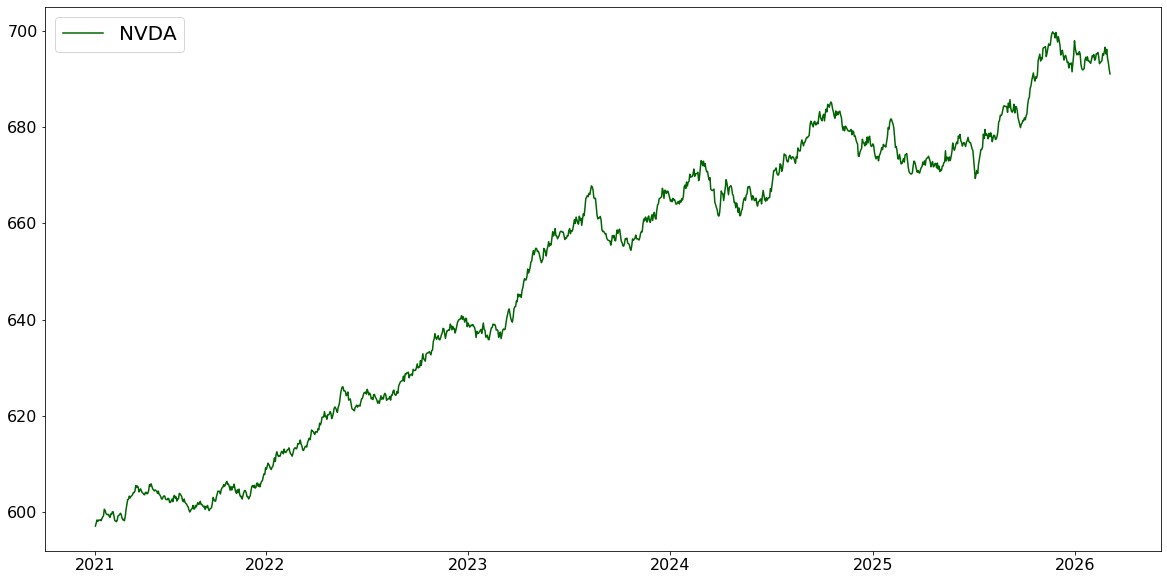

In [250]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1259)], res[1][1259:], label = 'NVDA', color = 'darkgreen')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend( prop={'size': 20})
plt.xticks([0, 211, 462, 713, 964, 1215], ['2021', '2022', '2023', '2024', '2025', '2026'])
plt.show()

### График цены Microsoft

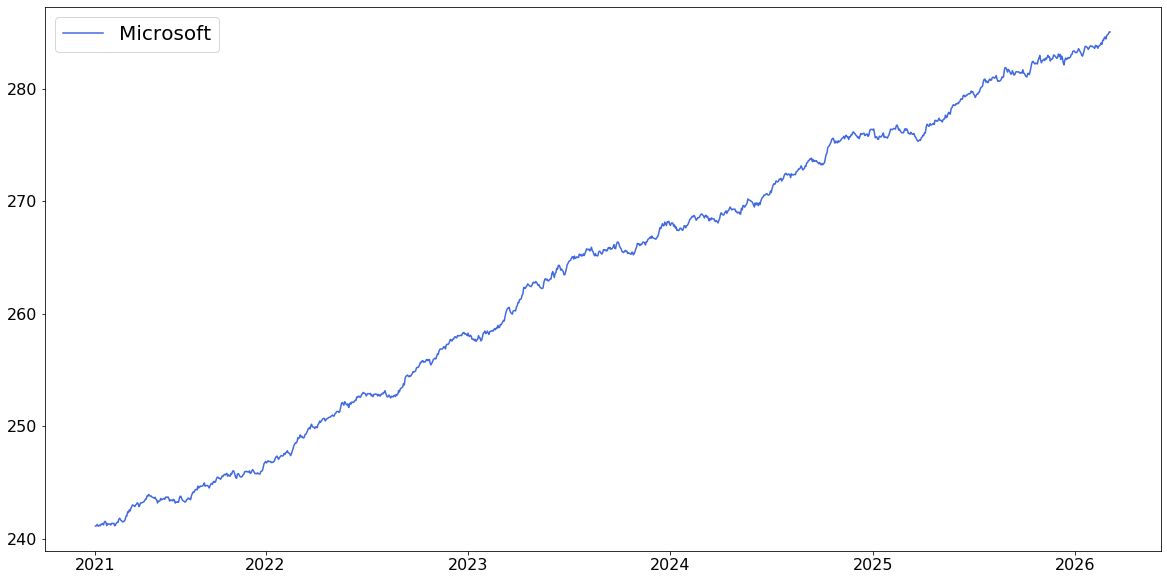

In [251]:
plt.figure(figsize=(20,10))
plt.plot([i for i in range(1259)], res[3][1259:], label = 'Microsoft', color = 'royalblue')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend( prop={'size': 20})
plt.xticks([0, 211, 462, 713, 964, 1215], ['2021', '2022', '2023', '2024', '2025', '2026'])
plt.show()